# MCT4052 Workshop 2b: Naïve Bayes Classifier v1

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

Classification in a type of supervised machine learning in which, given an input example, the model predicts a label. Labels can be represented by integer numbers (very handy programming-wise) or string of text.

This notebook provides a full example of supervised machine learning, starting from extracting features and labels from the dataset, arranging the training and testing set, training the system, and evaluating its performances. 

In this example we try to classify audio files according to three different classes.
We use a very basic classifier (naïve Bayesian) and a very simple set of features.
The goal is to understand the whole process including how to evaluate or interpret the results.

To use a richer set of features refer to what we covered in Workshop1. Moreover, the audio signals (wave files) have different lenght. Here we use the most basic approach, which is to compute the features over the entire duration and compress them by taking the mean. For more elabprated approaches, refer to Workshop1.

Since this is a supervised task we need labels. Files from different classes are all included in the same folder, but they are easily recognizable by their name. For classification purposes, best is to encode text labels using integer numbers (this can be a must for certain type of classifiers).

At first we will try to build a three numpy arrays which contains all key information, such as features, labels, and the associated file name (alternatively we can use a file ID and a separate table associating file names to file ID). It can be very important to keep track of raw data (i.e. file) from which we extracted the features, because often we may want to inspect files that are particularly hard to classify (perhaps they are outliers, or wrongly labeled, or noisy, etc.). Alternatively or in addition we can merge all the above in a single Pandas data frame.


In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use("seaborn-v0_8") 
import IPython.display as Ipd
import os


#import scikit-learn
import sklearn

%matplotlib widget
%config IPCompleter.greedy=True

### 1. Loading files from folder, one at a time, computing features N-dim array and labels array

In [2]:
sr = 22050

#Instead of writing the code to extract the features we define a function,
#which is more elegant, it's reusable (shorter code) and makes the following code more readable.
#All features are from librosa and are all scalar (we take the mean over multiple blocks computed across the duration, which differs for each file).
#The function returns a list containing the mean of the features given an filename, and the sampling rate at which we are resampling the file
#Mind that these features may not be the best to perform the classification task (it's just an example!)
def extract_features(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    output = [
        np.mean(librosa.feature.zero_crossing_rate(y=signal)),
        np.mean(librosa.feature.spectral_centroid(y=signal)),
        np.mean(librosa.feature.spectral_flatness(y=signal))
    ]
    
    return output


#creating an array of zeros of the proper size where we will store computed features and lables
filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),3)) #we compute the average of 3 features in the above code (3 must be changed if using more or less features)
labels = np.zeros((len(filenames))) #we store the labels as integers
classes = ['kick','snare','cymbal','clap'] #list of text labels to convert numberical labels to text labels

for i in range(len(filenames)):
    print('processing',filenames[i])
    features[i,:] = extract_features('./data/examples2/'+filenames[i], sr)
    if filenames[i].find('kick') != -1:
        labels[i] = 0
    elif filenames[i].find('snare') != -1:
        labels[i] = 1
    elif filenames[i].find('cymbal') != -1:
        labels[i] = 2
    elif filenames[i].find('clap') != -1:
        labels[i] = 3

print('Done!')

processing snare_28.wav
processing snare_00.wav
processing snare_14.wav
processing snare_15.wav
processing snare_01.wav
processing snare_29.wav
processing snare_17.wav
processing snare_03.wav
processing snare_02.wav
processing snare_16.wav
processing snare_12.wav
processing snare_06.wav
processing clap41.wav
processing clap40.wav
processing snare_07.wav
processing snare_13.wav
processing snare_05.wav
processing snare_11.wav
processing snare_39.wav
processing snare_38.wav
processing snare_10.wav
processing snare_04.wav
processing kick_07.wav
processing kick_13.wav
processing clap30.wav
processing clap24.wav
processing clap18.wav
processing cymbal29.wav
processing cymbal01.wav
processing cymbal15.wav
processing cymbal14.wav
processing cymbal00.wav
processing cymbal28.wav
processing clap19.wav
processing clap25.wav
processing clap31.wav
processing kick_12.wav
processing kick_06.wav
processing kick_10.wav
processing kick_04.wav
processing kick_38.wav
processing clap27.wav
processing clap33

### 2. Merging and storing everything in a data structure and reloading from the exported file.

In [3]:
#merging everything into a single data structure
dataset = pd.DataFrame(features)
dataset.columns = ['zcr','cent','flat'] #naming the features
dataset['label'] = labels
dataset['filename'] = filenames

#we can save the dataset to a file to resume working without re-computing the features (unless you want to change them)
dataset.to_csv('dataset2b.csv')
dataset

,zcr,cent,flat,label,filename
0,0.169678,3695.365330,0.125325,1.0,snare_28.wav
1,0.190479,3540.264963,0.065866,1.0,snare_00.wav
2,0.178561,3202.354810,0.067248,1.0,snare_14.wav
3,0.194885,3485.672493,0.106123,1.0,snare_15.wav
4,0.209131,4049.382265,0.096032,1.0,snare_01.wav
...,...,...,...,...,...
162,0.146918,2946.114851,0.052526,1.0,snare_18.wav
163,0.223836,3244.603741,0.100565,1.0,snare_19.wav
164,0.144997,3352.244606,0.052590,1.0,snare_31.wav
165,0.186811,3227.679367,0.051459,1.0,snare_25.wav


In [4]:
#now we reload from file and re-extract the three separate arrays containing features, labels, and filenames
dataset = pd.read_csv('dataset2b.csv')
features = dataset[['zcr','cent','flat']].to_numpy()
labels = dataset['label'] #we keep this as a pandas data structure, it will be handy to trace back misclassified files
filenames = dataset['filename'].tolist()
print(labels)
print(features)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
162    1.0
163    1.0
164    1.0
165    1.0
166    0.0
Name: label, Length: 167, dtype: float64
[[1.69677734e-01 3.69536533e+03 1.25325426e-01]
 [1.90478516e-01 3.54026496e+03 6.58664629e-02]
 [1.78560697e-01 3.20235481e+03 6.72475025e-02]
 [1.94885254e-01 3.48567249e+03 1.06122658e-01]
 [2.09130859e-01 4.04938226e+03 9.60324556e-02]
 [1.12092391e-01 2.77177826e+03 2.88370438e-02]
 [1.36369978e-01 3.60940334e+03 3.53584774e-02]
 [1.48646763e-01 3.06514067e+03 4.35181968e-02]
 [6.70247396e-02 2.25156967e+03 1.36784632e-02]
 [1.71875000e-01 3.21614548e+03 9.73966047e-02]
 [1.99934896e-01 3.91073410e+03 1.03983454e-01]
 [1.38392857e-01 3.73951748e+03 6.35018349e-02]
 [7.78364702e-02 1.61211028e+03 2.53520310e-01]
 [3.21178089e-01 3.00971322e+03 5.81901431e-01]
 [1.24837240e-01 3.93558746e+03 1.06695019e-01]
 [1.72407670e-01 2.83765252e+03 3.37114744e-02]
 [2.13964844e-01 4.07976376e+03 1.36257440e-01]
 [1.68823242e-01 3.350

### 3. Plotting the features in a scatter plot

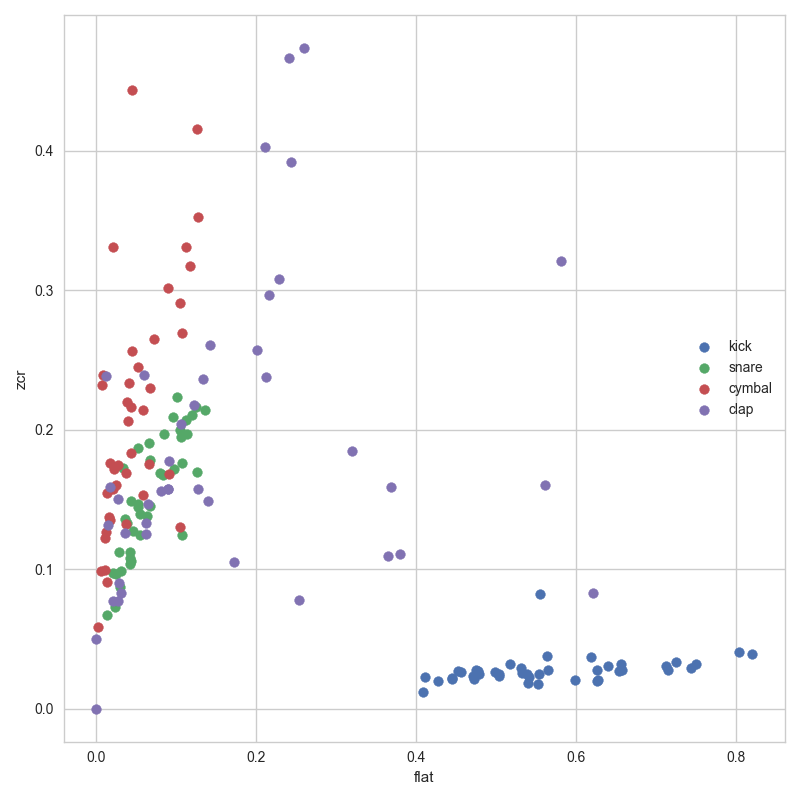

In [5]:
#Plotting the features in a 2D scatter plot
#we can plot up to 2 features (or you can attempt a 3D plot) 
#we also include an histrogram (different view of the same data)

#create a dictionary of features so that we can toggle between indexes and labels for each individual feature
feature_dict = {'zcr':0,
                'cent':1,
                'flat':2}

select1 = 'flat'
select2 = 'zcr'

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 8))
    for lab_val, lab_name in zip(range(0,50),classes):
        plt.scatter(features[labels==lab_val, feature_dict[select1]],
                    features[labels==lab_val, feature_dict[select2]],
                    label=lab_name)
    plt.xlabel(select1)
    plt.ylabel(select2)
    plt.legend(loc='center right')
    plt.tight_layout()
    plt.show()

### 4. Splitting the dataset in training and test set

Before proceeding with training and testing of the classifiers we split the data in training and testing set using a 70/30 partitioning.

Generally, before proceeding with the "learning" of any component of the overall ML system it is important to perform the split, and use only the training set for the learning. As you will see next, we also "learn" the scaling transformation, and to avoid biasing the system, we should always learn using only the training set.

This is done a useful function in scikit-learn (called train_test_split). The partitioning is done randomly but starting from a seed we can eventually specify and fix (random_state). Every time you change the starting random state value, you will experience a different partitioning and (likely) a different classification result.

In [6]:
#Importing the tool, alternatively you can call sklearn.model_selection.train_test_split(..,..,..,)
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.3, random_state=14)
print(features.shape)
print(feat_train.shape)
print(feat_test.shape)

(167, 3)
(116, 3)
(51, 3)


### 5. Scaling features

Here we use the *standard scaler* in scikit-learn to scale the features, this is important when using hetherogeneous (different) features. After this step all features will present zero mean and unit veriance (i.e. they are more comparable, this process is also called whitening). In this case we are overwiting the previous Numpy variable (or array) instead of creating a new one (it is fine if you do not need the old data anymore, and it reduces the number of variables you use in a program).

Scaling the features is reasonable after features have been selected (in case there is a stage of selection, crossing, elimination,reduction, etc...).

Mind that scaling should not be applied on array of features computed over time and vector features. In that case the function *normalize* is a more appropriate choice as demonstrated in 1c. Mind that *normalize* should not be applied here on the entire feature array, but at an earlier stage, right after computing the vector features. 

In [7]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
print('Train set mean and std before scaling',np.mean(feat_train, axis=0),np.std(feat_train, axis=0))
print('Test set mean and std before scaling',np.mean(feat_test, axis=0),np.std(feat_test, axis=0))

feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

print('Train set mean and std after scaling',np.mean(feat_train, axis=0),np.std(feat_train, axis=0))
print('Test set mean and std after scaling',np.mean(feat_test, axis=0),np.std(feat_test, axis=0))


Train set mean and std before scaling [1.49374376e-01 2.69059410e+03 1.99719215e-01] [9.69805710e-02 1.16926996e+03 2.19373957e-01]
Test set mean and std before scaling [1.30625937e-01 2.38517586e+03 2.45258441e-01] [1.07128033e-01 1.31419093e+03 2.58646838e-01]
Train set mean and std after scaling [-4.71844785e-16 -6.43642228e-16 -1.33992434e-16] [1. 1. 1.]
Test set mean and std after scaling [-0.1933216  -0.26120421  0.2075872 ] [1.10463396 1.12394142 1.17902253]


### 6. Creating, training and testing the classifier

For the options/parameters of the Gaussian Naive Bayes classifier that can be specified in the constructor refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Compared to other classifiers and ML techniques included in scikitlearn, the Gaussian Naive Bayes has very few parameters we can tweak to improve its performances.

In [8]:
#creating an instance of a Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

#creating an instannce of the classifier
model_GNB = GaussianNB()

#training the model
model_GNB.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict =  model_GNB.predict(feat_test)

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Number of mislabeled samples 10 out of 51
Accuracy: 0.803921568627451


### 7. Classification performance metrics

Accuracy is not only the only way to assess the performance of a classifier, often precision, recall or F1-score (still numbers between 0 and 1 where 1 is best) can do a better job (this is still application specific).

* *Precision*: It is implied as the measure of the correctly identified positive cases from all the predicted positive cases. Thus, it is useful when the costs of False Positives is high.

* *Recall*: It is the measure of the correctly identified positive cases from all the actual positive cases. It is important when the cost of False Negatives is high.

* *Accuracy*: One of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.

* *F1-score*: This is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.


Differences between the F1-score and the accuracy:
* Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial
* Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.
* In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.

The confusion matrix visualizes what gets missclassified as what.

An alternative way to evaluate a classifier is to use the Kappa score, which measures the the degree of "agreement" between the two evaluators (inter-rater reliability) which is this case are the human (labeled the data) and the ML model (generates the predicted labels).

#### For more detailed info check this [post](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2) (it comes in 3 parts).

In [9]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

print(sklearn.metrics.confusion_matrix(lab_test, lab_predict))

print("\nKappa score = ", sklearn.metrics.cohen_kappa_score(lab_test, lab_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        17
         1.0       0.86      0.86      0.86        14
         2.0       0.62      0.73      0.67        11
         3.0       0.57      0.44      0.50         9

    accuracy                           0.80        51
   macro avg       0.76      0.76      0.76        51
weighted avg       0.80      0.80      0.80        51

[[17  0  0  0]
 [ 0 12  2  0]
 [ 0  0  8  3]
 [ 0  2  3  4]]

Kappa score =  0.7329842931937173


### 8. Backtracing misclassified files

Sometime misclassification is fue to outliers, spurious data or wrongly labeled data. Therefore it is important to be able to backtrace misclassifies files and preaphs analyze them (e.g. listen to them in this case). This may give us hints on features to be added to improve the classification accuracy.

In [10]:
#displaying names of misclassified files
results = lab_test == lab_predict
for index, value in enumerate(results):
    if value == False:
        print(filenames[index])


snare_14.wav
snare_15.wav
snare_06.wav
snare_13.wav
snare_05.wav
snare_04.wav
cymbal29.wav
cymbal15.wav
cymbal00.wav
clap27.wav


### 9. Confusion matrix visualization

This function provides a better visualization of the Confu matrix. The Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. This gives us a holistic view of how well our classification model is performing and what kinds of errors it is making.

Confusion matrix, without normalization
[[17  0  0  0]
 [ 0 12  2  0]
 [ 0  0  8  3]
 [ 0  2  3  4]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.86 0.14 0.  ]
 [0.   0.   0.73 0.27]
 [0.   0.22 0.33 0.44]]


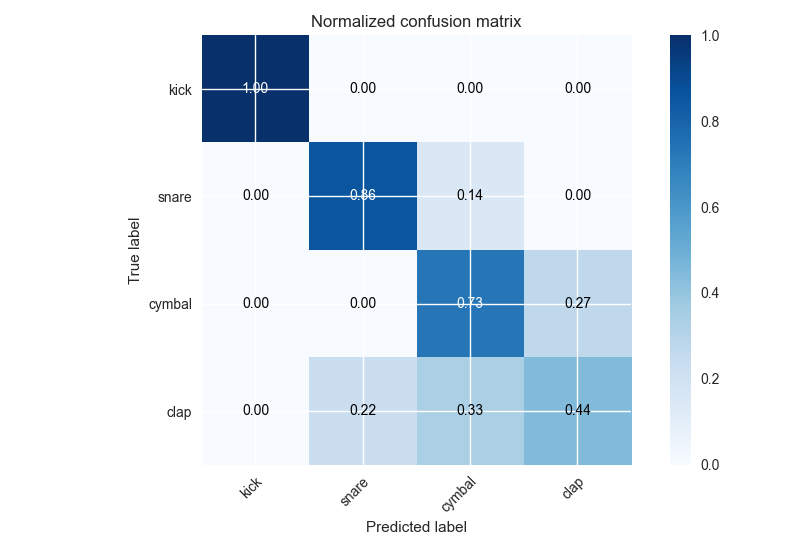

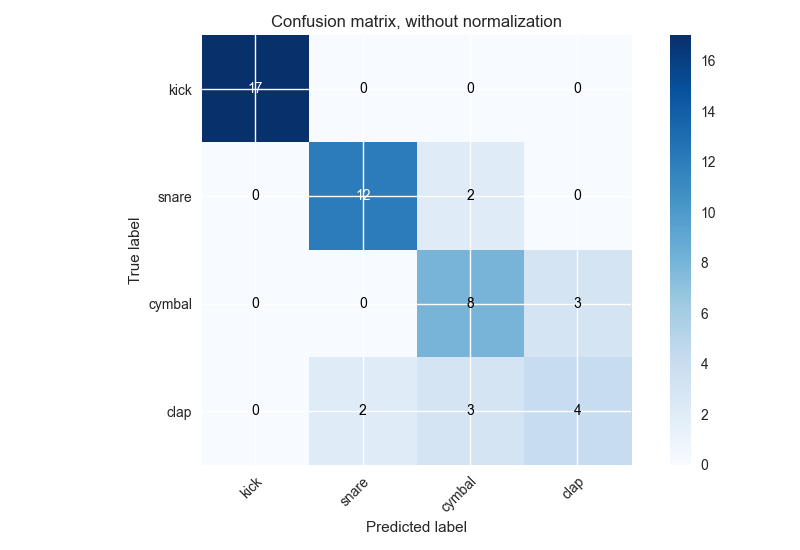

In [11]:
#this is a better way of visualizing the confusion matrix

#defining a function for the confusion matrix display 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#setting the precision to two digits after the decimal point
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(lab_test, lab_predict, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(lab_test, lab_predict, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 10. Follow-up activity

1. Identify and mark the sections of this notebook that are absolutely necessary to train and test the classifier, as well those that can be removed.
2. Change or add more features, or more statistical moment (e.g. variance), or both to improve the accuracy.
3. Try with different classifiers included in scikit learn.
4. Try different ratio/random_state when splitting the database in train/test set